# 모듈

In [1]:
import numpy as np 
import pandas as pd
import os
import re
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

# train data load

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/Question_pair-master/kor_pair_train.csv')
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1


In [3]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 6888


In [4]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
train_set.head()

0         1000일 만난 여자친구와 이별
1      10년 연애사 되돌아보니 다 부질없네
2               10년만나다 헤어지네
3    10월의 마지막밤 . 더 보고싶네 그사람
4             14년의 기나긴 이야기.
dtype: object

In [5]:
print('전체 질문의 개수: {}'.format(len(train_set)))
print('전체 질문 중 유니크한 질문 수: {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 질문의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

전체 질문의 개수: 13776
전체 질문 중 유니크한 질문 수: 12654
반복해서 나타나는 질문의 수: 1109


# label 수 확인

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


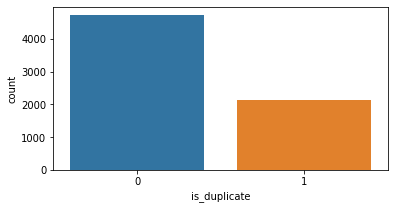

In [6]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['is_duplicate'])

# 각 질문 길이(띄어쓰기 포함 글자수) 분포 확인

Text(0, 0.5, 'Probability')

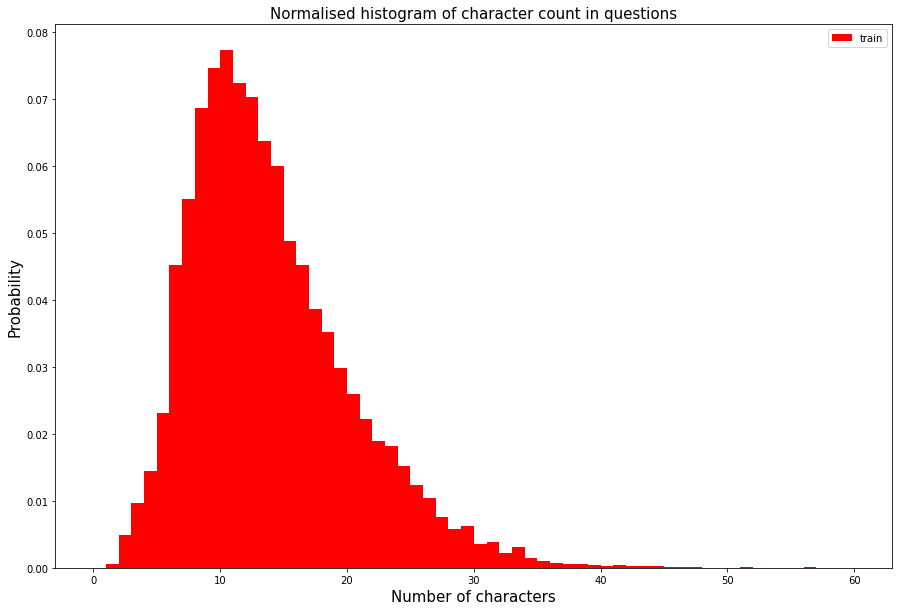

In [7]:
train_length = train_set.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=60, range=[0,60], facecolor='r', density=True, label='train')
plt.title("Normalised histogram of character count in questions", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [8]:
print('질문 길이 최대 값: {}'.format(np.max(train_length)))
print('질문 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('질문 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('질문 길이 중간 값: {}'.format(np.median(train_length)))
print('질문 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('질문 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

질문 길이 최대 값: 56
질문 길이 평균 값: 13.45
질문 길이 표준편차: 6.31
질문 길이 중간 값: 12.0
질문 길이 제 1 사분위: 9.0
질문 길이 제 3 사분위: 17.0


{'boxes': [<matplotlib.lines.Line2D at 0x7fc037e89210>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc037e91250>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc037e977d0>],
 'means': [<matplotlib.lines.Line2D at 0x7fc037e97290>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc037e91d10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc037f6a890>,
  <matplotlib.lines.Line2D at 0x7fc037e89cd0>]}

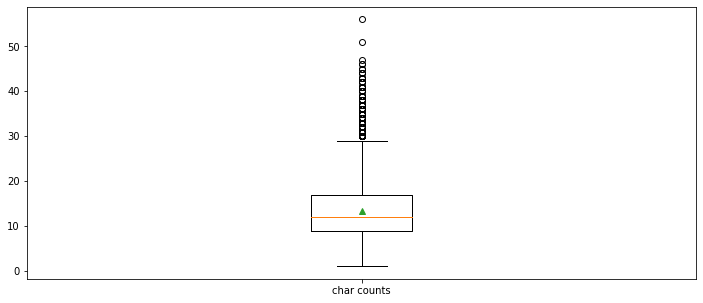

In [9]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

# 각 질문의 단어 분포 확인

In [10]:
# 단어의 개수 파악
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))
train_word_counts

0        4
1        5
2        2
3        6
4        3
        ..
13771    4
13772    2
13773    3
13774    7
13775    4
Length: 13776, dtype: int64

Text(0, 0.5, 'Prabability')

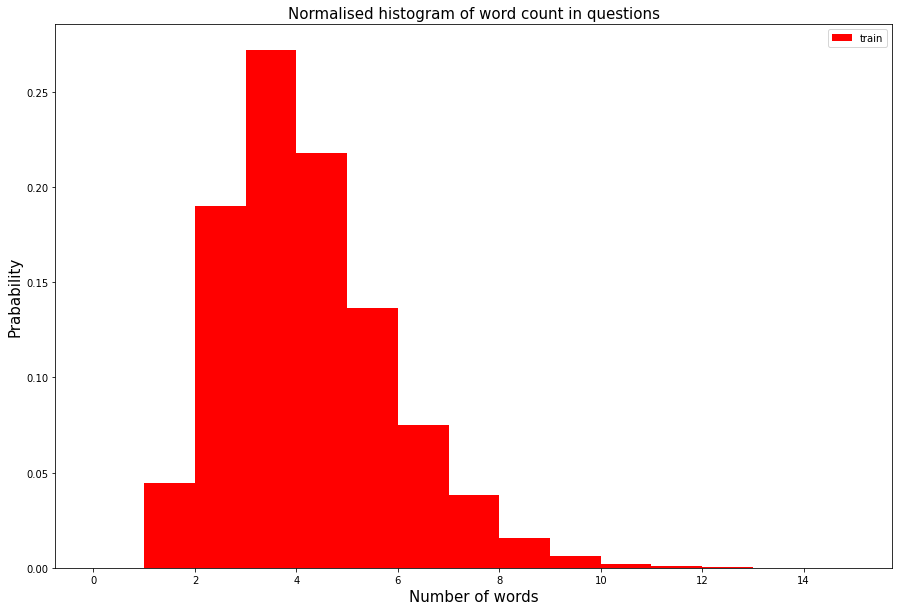

In [11]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=15, range=[0, 15], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [12]:
print('질문 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('질문 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('질문 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

질문 단어 개수 최대 값: 15
질문 단어 개수 평균 값: 3.73
질문 단어 개수 표준편차: 1.65
질문 단어 개수 중간 값: 3.0
질문 단어 개수 제 1 사분위: 3.0
질문 단어 개수 제 3 사분위: 5.0
질문 단어 개수 99 퍼센트: 8.0


{'boxes': [<matplotlib.lines.Line2D at 0x7fc037dae750>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc037db3790>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc037dbbd10>],
 'means': [<matplotlib.lines.Line2D at 0x7fc037dbb7d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc037dbb290>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc037daecd0>,
  <matplotlib.lines.Line2D at 0x7fc037db3250>]}

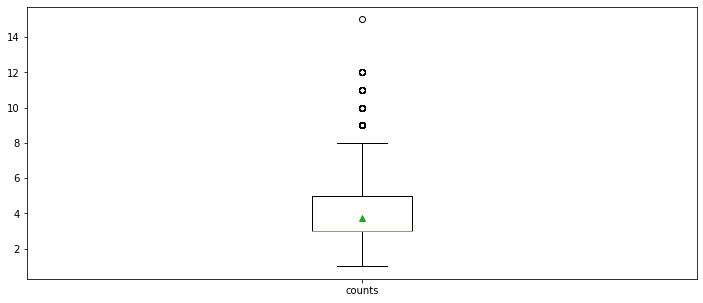

In [13]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

In [14]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개

print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표를 포함한 질문: {:.2f}%'.format(fullstop * 100))
print('숫자가있는 질문: {:.2f}%'.format(numbers * 100))

물음표가있는 질문: 16.44%
마침표를 포함한 질문: 20.25%
숫자가있는 질문: 2.82%


# 데이터 전처리

In [15]:
FILTERS = "([^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z])"
MAX_SEQUENCE_LENGTH = 8

change_filter = re.compile(FILTERS)

In [16]:
# label 값 동일하게 data 개수 맞추기
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1] # ==> 2138
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0] # ==> 4750

class_difference = len(train_neg_data) - len(train_pos_data)
# print(class_difference) ==> 2612
sample_frac = 1 - (class_difference / len(train_neg_data))
# print(sample_frac) ==> 0.4501052631578948

train_neg_data = train_neg_data.sample(frac = sample_frac)
# print(len(train_neg_data)) ==> 2138

print("일치하는 질문 개수: {}".format(len(train_pos_data)))
print("불일치하는 질문 개수: {}".format(len(train_neg_data)))

일치하는 질문 개수: 2138
불일치하는 질문 개수: 2138


In [17]:
train_data = pd.concat([train_neg_data, train_pos_data])
train_data

,id,qid1,qid2,question1,question2,is_duplicate
3232,3233,6465,6466,썸 타는 것 같은데 조언해줘.,썸 타는 것 같은데 조언 좀.,0
2766,2767,5533,5534,삼겹살 냄새,삼겹살 냄새 다 벴어,0
503,504,1007,1008,그만 먹어야 하는데,먹을까 참을까,0
6290,6291,12581,12582,커피나 한 잔 하자고 말 해볼까,차 한 잔 하자고 해볼까,0
4831,4832,9663,9664,이직각인가,이직해야할지 고민이야,0
...,...,...,...,...,...,...
6880,6881,13761,13762,AB형 남자랑 썸 타면,AB형 여자랑 썸 타면,1
6882,6883,13765,13766,B형 여자랑 썸 탐.,CC 레알 별로임?,1
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1


In [18]:
change_filter = re.compile(FILTERS)

questions1 = [str(s) for s in train_data['question1']]
questions2 = [str(s) for s in train_data['question2']]

print(questions1[:5])
print(questions2[:5])

['썸 타는 것 같은데 조언해줘.', '삼겹살 냄새', '그만 먹어야 하는데', '커피나 한 잔 하자고 말 해볼까', '이직각인가']
['썸 타는 것 같은데 조언 좀.', '삼겹살 냄새 다 벴어', '먹을까 참을까', '차 한 잔 하자고 해볼까', '이직해야할지 고민이야']


In [19]:
filtered_questions1 = list()
filtered_questions2 = list()

for sentence in questions1:
    sentence1 = []
    sentence = sentence.split()
    for word in sentence:
        sentence1.append(re.sub(change_filter, "", word))
    new_sentence = ' '.join(sentence1)
    filtered_questions1.append(new_sentence)
        
for sentence in questions2:
    sentence2 = []
    sentence = sentence.split()
    for word in sentence:
        sentence2.append(re.sub(change_filter, "", word))
    new_sentence = ' '.join(sentence2)
    filtered_questions2.append(new_sentence)
    

print(filtered_questions1[:5])
print(filtered_questions2[:5])

['썸 타는 것 같은데 조언해줘', '삼겹살 냄새', '그만 먹어야 하는데', '커피나 한 잔 하자고 말 해볼까', '이직각인가']
['썸 타는 것 같은데 조언 좀', '삼겹살 냄새 다 벴어', '먹을까 참을까', '차 한 잔 하자고 해볼까', '이직해야할지 고민이야']


## 토크나이징

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_questions1 + filtered_questions2)

questions1_sequence = tokenizer.texts_to_sequences(filtered_questions1)
questions2_sequence = tokenizer.texts_to_sequences(filtered_questions2)
print(questions1_sequence[:5])
print(questions2_sequence[:5])

[[14, 48, 16, 77, 3872], [711, 712], [234, 2027, 151], [3873, 62, 528, 844, 88, 116], [3874]]
[[14, 48, 16, 77, 599, 11], [711, 712, 27, 7214], [975, 7215], [580, 62, 528, 844, 116], [7216, 243]]


## 패딩 처리

In [21]:
q1_data = pad_sequences(questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
q2_data = pad_sequences(questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(q1_data[0])
print(q2_data[0])

[  14   48   16   77 3872    0    0    0]
[ 14  48  16  77 599  11   0   0]


# 단어 사전 만들기

In [22]:
word_vocab = {}
word_vocab = tokenizer.word_index 
word_vocab["<PAD>"] = 0

labels = np.array(train_data['is_duplicate'], dtype=int)

print('Shape of question1 data: {}'.format(q1_data.shape))
print('Shape of question2 data:{}'.format(q2_data.shape))
print('Shape of label: {}'.format(labels.shape))
print("Words in index: {}".format(len(word_vocab)))

Shape of question1 data: (4276, 8)
Shape of question2 data:(4276, 8)
Shape of label: (4276,)
Words in index: 10306


In [23]:
word_vocab
'''
{'좋아하는': 1,
 '너무': 2,
 '거': 3,
 '싶어': 4,
 '같아': 5,
 '나': 6,

 ...

 '누구': 995,
 '목': 996,
 '때가': 997,
 '너는': 998,
 '하러': 999,
 '있다면': 1000,
 
 ...}
 '''

"\n{'좋아하는': 1,\n '너무': 2,\n '거': 3,\n '싶어': 4,\n '같아': 5,\n '나': 6,\n\n ...\n\n '누구': 995,\n '목': 996,\n '때가': 997,\n '너는': 998,\n '하러': 999,\n '있다면': 1000,\n \n ...}\n "

In [24]:
prepro_configs = {}
prepro_configs['vocab'] = word_vocab
prepro_configs['vocab_size'] = len(word_vocab)

In [48]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/Question_pair-master/kor_Pair_test.csv', encoding='utf-8')
test_data

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [26]:
test_questions1 = [str(s) for s in test_data['question1']]
test_questions2 = [str(s) for s in test_data['question2']]

print(test_questions1[:5])
print(test_questions2[:5])

filtered_test_questions1 = list()
filtered_test_questions2 = list()

for sentence in test_questions1:
    sentence1 = []
    sentence = sentence.split()
    for word in sentence:
        sentence1.append(re.sub(change_filter, "", word))
    new_sentence = ' '.join(sentence1)
    filtered_test_questions1.append(new_sentence)
        
for sentence in test_questions2:
    sentence2 = []
    sentence = sentence.split()
    for word in sentence:
        sentence2.append(re.sub(change_filter, "", word))
    new_sentence = ' '.join(sentence2)
    filtered_test_questions2.append(new_sentence)
    

print(filtered_test_questions1[:5])
print(filtered_test_questions2[:5])


['21살의 사랑에 대해', '2년 가량의 연애', '2년 만난 기념일이야', '2년 사귀었는데 결혼하려고', '5급면제도 나랑사랑카드 발급하나요?']
['사랑을 노력한다는게 말이 되나요?', '2년 만났어', '우리 벌써 2년 동안 사궜어', '2년째 짝사랑하는 사람이 있어.', '아이콘 노래 사랑을 했다 별로인것같은데']
['21살의 사랑에 대해', '2년 가량의 연애', '2년 만난 기념일이야', '2년 사귀었는데 결혼하려고', '5급면제도 나랑사랑카드 발급하나요']
['사랑을 노력한다는게 말이 되나요', '2년 만났어', '우리 벌써 2년 동안 사궜어', '2년째 짝사랑하는 사람이 있어', '아이콘 노래 사랑을 했다 별로인것같은데']


In [27]:
test_questions1_sequence = tokenizer.texts_to_sequences(filtered_test_questions1)
test_questions2_sequence = tokenizer.texts_to_sequences(filtered_test_questions2)

print(test_questions1_sequence[:5])
print(test_questions2_sequence[:5])

[[8386, 341, 745], [399, 1810, 44], [399, 281], [399, 5017], []]
[[225, 5853, 323, 5854], [399, 214], [157, 156, 399, 2347], [3208, 388, 15, 26], [236, 225, 9039]]


In [28]:
test_q1_data = pad_sequences(test_questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_q2_data = pad_sequences(test_questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(test_q1_data[0])
print(test_q2_data[0])

[8386  341  745    0    0    0    0    0]
[ 225 5853  323 5854    0    0    0    0]


In [29]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [36]:
DATA_OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/'
model_name = 'malstm_similarity'
BATCH_SIZE = 2
NUM_EPOCHS = 20
VALID_SPLIT = 0.1

kargs = {
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_dimension': 100,
    'lstm_dimension': 150,
}

In [32]:
class MaLSTM(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])
        
    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))
        
        return x

In [38]:
model = MaLSTM(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [39]:
checkpoint_path = DATA_OUT_PATH + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True)

In [40]:
history = model.fit((q1_data, q2_data), 
                    labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT,
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/20
1924/1924 [==============================] - 25s 12ms/step - loss: 2.4673 - accuracy: 0.3780 - val_loss: 0.6300 - val_accuracy: 0.6472

Epoch 00001: val_accuracy improved from -inf to 0.64720, saving model to /content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/weights.h5
Epoch 2/20
1924/1924 [==============================] - 22s 12ms/step - loss: 2.2305 - accuracy: 0.5504 - val_loss: 0.4736 - val_accuracy: 0.7944

Epoch 00002: val_accuracy improved from 0.64720 to 0.79439, saving model to /content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/weights.h5
Epoch 3/20
1924/1924 [==============================] - 23s 12ms/step - loss: 2.1326 - accuracy: 0.7839 - val_loss: 0.7498 - val_accuracy: 0.7664

Epoch 00003: val_accuracy did not improve from 0.79439
Epoch 4/20
1924/1924 [==============================] - 23s 12ms/step - loss: 1.8907 - accuracy: 0.8188 - val_loss: 1.0091 - val_accuracy: 0.8131

Epoch 00004: val_accuracy improved from 0.79439 to 0.81308, saving model to /content

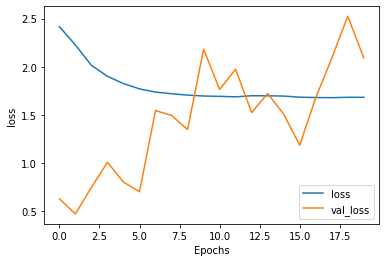

In [41]:
plot_graphs(history, 'loss')

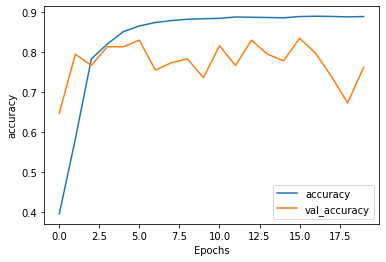

In [42]:
plot_graphs(history, 'accuracy')

In [43]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/TF-IDF_Test/weights.h5')
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

In [44]:
result = pd.DataFrame({'prediction':predictions})
result

,prediction
0,9.996631e-01
1,9.999493e-01
2,9.965667e-01
3,9.999027e-01
4,9.997408e-01
...,...
683,5.239674e-01
684,1.700795e-14
685,1.037596e-03
686,9.998909e-01


In [49]:
test_df = test_data.iloc[:,1:4]
test_df

,question1,question2,is_duplicate
0,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2년 가량의 연애,2년 만났어,0
2,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...
683,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,휴대폰 액정 깨졌어,액정 깨짐,0
686,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [50]:
def answer(x):
    if x > 0.5:
        return 1
    else:
        return 0

result.prediction = result.prediction.map(answer)
result

,prediction
0,1
1,1
2,1
3,1
4,1
...,...
683,1
684,0
685,0
686,1


In [51]:
result_df = pd.concat([test_df, result], axis=1)
result_df

,question1,question2,is_duplicate,prediction
0,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,1
1,2년 가량의 연애,2년 만났어,0,1
2,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,1
3,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,1
4,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,1
...,...,...,...,...
683,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1
684,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,0
685,휴대폰 액정 깨졌어,액정 깨짐,0,0
686,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,1


In [52]:
np.mean(result_df.is_duplicate == result_df.prediction)

0.5755813953488372